<a href="https://colab.research.google.com/github/letianzj/QuantResearch/blob/master/ml/reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Monte Carlo Policy Gradient CartPole

Use MC-PG, a.k.a REINFORCE, to solve CartPole game.

[OpenAI Gym CartPole](https://gym.openai.com/envs/CartPole-v0/) has four states, cart position, cart speed, pole angle, and pole speed. The actions are either going left or right. The objective is to keep pole from falling. Every move that doesn't lead to a fall gets reward 1.

Monte-Carlo policy gradient is on-policy model-free sampling method. The expected total rewards,

$$
J(\theta)=E_{\tau \sim \pi_{\theta}(\tau)}[R(\tau)]=\int R(\tau) p_{\theta}(\tau)d\tau
$$

and its derivative on policy parameter $\theta$ is,

$$
\begin{aligned}
\frac{\partial J}{\partial \theta}&=\int \left( \frac{\partial}{\partial \theta} p_{\theta}(\tau) \right) R(\tau)d\tau \\
&=\int p_{\theta}(\tau) \left(\frac{\partial}{\partial\theta}log p_{\theta}(\tau)\right) R(\tau)d\tau \\
&=E_{\tau \sim \pi_{\theta}(\tau)} \left[\frac{\partial}{\partial\theta}log p_{\theta}(\tau) R(\tau) \right] \\
&=E_{\tau \sim \pi_{\theta}(\tau)} \left[\sum_{t=1}^{T} \frac{\partial}{\partial\theta}log \left( \pi_{\theta}(a_t|s_t) \right)R(\tau) \right] \\
&\approx \frac{1}{N} \sum_{n=1}^N \left( \left( \sum_{t=1}^{T} \frac{\partial}{\partial \theta} log \pi_{\theta} \left( a_t^{(n)} | s_t^{(n)}\right) \right) R\left(\tau^{(n)}\right) \right)
\end{aligned}
$$

Policy gradient updates parameters iteratively along every sample trajectory. We can calculate the gradient directly, or construct a cross-entropy loss function whose gradient is equal to the policy gradient as well explained [here](https://adventuresinmachinelearning.com/policy-gradient-tensorflow-2/). 

$$
Loss= CE = \left( \sum_{t=1}^{T} logp_{\theta} \left( a_t^{(n)} | s_t^{(n)}\right) \right) R\left(\tau^{(n)}\right)
$$

Below it uses the former and code structure follows closely [here](https://github.com/dragen1860/Deep-Learning-with-TensorFlow-book/blob/master/ch14-%E5%BC%BA%E5%8C%96%E5%AD%A6%E4%B9%A0/REINFORCE_tf.py).

REINFORCE is usually adjusted by a baseline to reduce variance.


__Reference__
* Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. MIT press, 2018.
* [RL by David Silver](https://www.davidsilver.uk/teaching/)
* [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/)
* [Lil'Log](https://lilianweng.github.io/lil-log/)
* [Deep Learning with TensorFlow](https://github.com/dragen1860/Deep-Learning-with-TensorFlow-book)

In [18]:
import gym
import numpy as np
from 	matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers

env = gym.make('CartPole-v1')
print(f'CartPole state {env.observation_space.shape[0]},  action {env.action_space.n}') # state size = 4, action = 0 or 1
env.seed(5555)
tf.random.set_seed(5555)
np.random.seed(5555)

epoch = 300
learning_rate = 0.0002
gamma = 0.98
reward_to_go = True

class Policy(keras.Model):
    def __init__(self):
        super(Policy, self).__init__()
        self.fc1 = layers.Dense(128, kernel_initializer='he_normal', activation='tanh')
        self.fc2 = layers.Dense(2, kernel_initializer='he_normal', activation=None)
        self.optimizer = optimizers.Adam(lr=learning_rate)

    def call(self, inputs, training=None):
        x = self.fc1(inputs)          # [b, 4]  ==> [b 32]
        x = self.fc2(x)               # [b, 32] ==> [b, 2]
        # x = tf.nn.softmax(x, axis=1)       # return prob instead of logits
        return x

model = Policy()
model(tf.random.normal((10,4)))           # batch=10, output=(10,2)
model.summary()

CartPole state 4,  action 2
Model: "policy_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             multiple                  640       
_________________________________________________________________
dense_15 (Dense)             multiple                  258       
Total params: 898
Trainable params: 898
Non-trainable params: 0
_________________________________________________________________


In [19]:
scores = []

for n_epi in range(epoch):             # epoch
    with tf.GradientTape(persistent=True) as tape:
        s = env.reset()          # return s0
        done = False
        log_probs = []
        rs = []

        # sample one game, one trajectory
        while not done:
            s = tf.constant(s,dtype=tf.float32)
            s = tf.expand_dims(s, axis=0)                   # [4] => [1,4]
            logits = model(s)                                    # shape = [1, 2]
            a = tf.random.categorical(logits, 1)[0]           # categorical accepts logits, not prob
            a = int(a)                                      # Tensor to int
            s_prime, r, done, info = env.step(a)
            rs.append(r)                                 # rewards
            prob = tf.nn.softmax(logits)                 # take softmax
            log_probs.append(tf.math.log(prob[0][a]))    # log(prob)
            s = s_prime
        
        scores.append(np.sum(rs))
        # print(f"# of episode :{n_epi}, avg score : {scores[-1]}")

        # after game over, for each time step, update parameters
        rs = tf.convert_to_tensor(rs, dtype=tf.float32)
        log_probs = tf.convert_to_tensor(log_probs, dtype=tf.float32)

        R = 0                                     # reward to go
        LP = 0                                    # log\pi to go
        for t in range(len(rs)-1, -1, -1):
            R = rs[t] + gamma * R
            LP = LP + log_probs[t]
            loss = - LP * R                 # negative sign means gradient ascent
            with tape.stop_recording():
                grads = tape.gradient(loss, model.trainable_variables)
                model.optimizer.apply_gradients(zip(grads, model.trainable_variables))  
        # rts = [np.sum(rs[i:]) for i in range(len(rs))]
        # rts = tf.convert_to_tensor(rts, dtype=tf.float32)
        # log_probs = tf.convert_to_tensor(log_probs, dtype=tf.float32)
        # if reward_to_go:
        #     loss = - tf.math.reduce_sum(log_probs * rts)         # use r(tau)_t:T; negative sign means gradient ascent
        # else:
        #     loss = - tf.math.reduce_sum(log_probs * rts[0])      # use r(tau); negative sign means gradient ascent
        # grads = tape.gradient(loss, model.trainable_variables)
        # model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

    del tape
    
env.close()

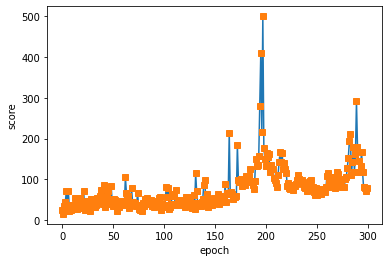

In [23]:
plt.plot(np.arange(epoch), scores)
plt.plot(np.arange(epoch), scores, 's')
plt.xlabel('epoch')
plt.ylabel('score')
plt.show()